In [1]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
%matplotlib notebook
import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point; # Shapely for converting latitude/longtitude to geometry
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

import geopy.distance
from geopy.geocoders import Nominatim
import json;



import traveltimepy as ttpy
import os
from datetime import datetime #for examples
#TODO: store credentials in an environment variable
os.environ["TRAVELTIME_ID"] = '466b4c75'
os.environ["TRAVELTIME_KEY"] = 'aa473fed8d8638f1b576305a7e1fc019'

pd.set_option('display.precision', 1)



In [2]:
#Load Distribution Centre Data
df = pd.read_excel(r'DistributionCentres.xlsx', sheet_name='master')
df

,Line,Corp Name,Company Name,Initial Target,Building Name,Address,City,Region,PostCode,PostCode Sector,...,SFO Category,Bldg Size (k sq ft),SFO = Bldg,# Emp,Industry Type,Location,Submarket,Web Address,Unnamed: 31,Unnamed: 32
0,400,4PX Express,4PX Express UK,NaN,Dunstable 240,Arenson Way,Dunstable,East of England,LU5 4SB,LU5,...,200-500,200-249.9,Yes,0,"Professional, Scientific, and Technical Services",Main HQ Corp/LLC,West Bedfordshire Ind,http://en.4px.com/,NaN,NaN
1,572,4PX Express,4PX Express,NaN,Northampton 250,Weedon Rd,Northampton,East Midlands,NN7 3NF,NN7,...,200-500,200-249.9,Yes,0,Transportation and Warehousing,Single Location,Northamptonshire South In,NaN,NaN,NaN
2,359,4PX Express UK Co Ltd,4PX Express UK Co Ltd,NaN,Leicester 335,Leicester Ln,Leicester,East Midlands,LE19 1SA,LE1,...,200-500,250 to 499.9,Yes,0,Transportation and Warehousing,NaN,Blaby Ind,NaN,NaN,NaN
3,94,A Steadman and Son Ltd,A Steadman and Son Ltd,NaN,Steadmans,Wanell,Carlisle,North West,CA5 7HH,CA5,...,200-500,200-249.9,Yes,0,Manufacturing,Main HQ,Allerdale Ind,NaN,NaN,NaN
4,894,A.F.Blakemore and Son Ltd,A.F.Blakemore and Son Ltd,NaN,A F Blakemore & Son Ltd,Longacre,Willenhall,West Midlands,WV13 2JP,WV1,...,200-500,200-249.9,Yes,0,NaN,Divisional HQ,Walsall Ind,http://www.spar-international.com,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,461,Yusen Logistics,Yusen Logistics,3PL,NYK Building,Bradbourne Dr,Milton Keynes,South East,MK7 8BN,MK7,...,200-500,250 to 499.9,Yes,0,Transportation and Warehousing,NaN,Milton Keynes Ind,NaN,NaN,NaN
902,536,Yusen Logistics,Yusen Logistics,3PL,NaN,Cheaney Dr,Northampton,East Midlands,NN4 5FB,NN4,...,200-500,200-249.9,Yes,200,"Professional, Scientific, and Technical Services",Main HQ Corp/LLC,Northamptonshire South In,https://www.yusen-logistics.com,NaN,NaN
903,578,Yusen Logistics,Yusen Logistics,3PL,Yusen Logistics,Rutherford Dr,Wellingborough,East Midlands,NN8 6AQ,NN8,...,200-500,250 to 499.9,Yes,150,Transportation and Warehousing,Warehouse Corp/LLC,Wellingborough Ind,www.yusen-logistics.com,NaN,NaN
904,579,Yusen Logistics,Yusen Logistics,3PL,Yusen Logistics,Sywell Rd,Wellingborough,East Midlands,NN8 6BS,NN8,...,200-500,250 to 499.9,Yes,0,Transportation and Warehousing,Warehouse Corp/LLC,Wellingborough Ind,https://www.yusen-logistics.com/,NaN,NaN


In [3]:
#Set up terminal options
data = [['Chatterlea Valley', 53.0605255,-2.2298863, (5,5)], ['Meaford Business Park', 52.9245709,-2.1716336, (5,-5)], ['Meaford Power Station', 52.9290919,-2.1753619, (5,5)], ['Chatsworth Park Avenue', 52.9833904,-2.1906224, (5,5)], ['Hixon Airfield', 52.832255,-2.009612,  (5,5)]]
  
# Create the pandas DataFrame
all_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long', 'map_offset'])  

# creating a geometry column 
geometry_all = [Point(xy) for xy in zip(all_locations['Long'], all_locations['Lat'])]

# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
all_points = gpd.GeoDataFrame(all_locations, crs=crs, geometry=geometry_all)

all_points

,Terminal,Lat,Long,map_offset,geometry
0,Chatterlea Valley,53.1,-2.2,"(5, 5)",POINT (-2.22989 53.06053)
1,Meaford Business Park,52.9,-2.2,"(5, 5)",POINT (-2.17163 52.92457)
2,Meaford Power Station,52.9,-2.2,"(5, -5)",POINT (-2.17536 52.92909)
3,Chatsworth Park Avenue,53.0,-2.2,"(5, 5)",POINT (-2.19062 52.98339)
4,Hixon Airfield,52.8,-2.0,"(5, 5)",POINT (-2.00961 52.83226)


In [4]:
#Inclusion & Exclusion Criteria

slice = df.rename(columns={'SFO (m)': 'sf_occupied_million', 'PostCode Sector': 'PostCode_District', 'PostCode Area': 'PostCode_Area'})
slice['PostCode_District'] = slice['PostCode'].str.extract(r'([^\s]+)')
slice.drop(columns = ['# Emp', 'Location', 'Submarket', 'Initial Target', 'City', 'Corp Name', 'Country', 'Ten_Phone', 'Sites', 'NUTS1 Reg based on sector', 'Region', 'Web Address', 'Unnamed: 31', 'Unnamed: 32', 'SFO = Bldg', 'SFO Category', 'Bldg Size (k sq ft)'], inplace=True)
slice

,Line,Company Name,Building Name,Address,PostCode,PostCode_District,PostCode_Area,PostCode Area Name,PCA Cluster,Lat,Lon,IM Terminal in PC Area,IM Terminal,SF Occupied,sf_occupied_million,Industry Type
0,400,4PX Express UK,Dunstable 240,Arenson Way,LU5 4SB,LU5,LU,Luton,NaN,51.9,-0.4,No IM Terml,None,241092,0.2,"Professional, Scientific, and Technical Services"
1,572,4PX Express,Northampton 250,Weedon Rd,NN7 3NF,NN7,NN,Northampton,Daventry,52.2,-0.9,FGL 3rd Party,Dav DIRFT,249579,0.2,Transportation and Warehousing
2,359,4PX Express UK Co Ltd,Leicester 335,Leicester Ln,LE19 1SA,LE19,LE,Leicester,Nottingham,52.6,-1.1,No IM Terml,None,335158,0.3,Transportation and Warehousing
3,94,A Steadman and Son Ltd,Steadmans,Wanell,CA5 7HH,CA5,CA,Carlisle,NaN,54.9,-2.9,No IM Terml,None,248333,0.2,Manufacturing
4,894,A.F.Blakemore and Son Ltd,A F Blakemore & Son Ltd,Longacre,WV13 2JP,WV13,WV,Wolverhampton,NaN,52.6,-2.1,No IM Terml,None,248004,0.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,461,Yusen Logistics,NYK Building,Bradbourne Dr,MK7 8BN,MK7,MK,Milton Keynes,NaN,52.0,-0.7,No IM Terml,None,302585,0.3,Transportation and Warehousing
902,536,Yusen Logistics,NaN,Cheaney Dr,NN4 5FB,NN4,NN,Northampton,Daventry,52.2,-0.9,FGL 3rd Party,Dav DIRFT,210000,0.2,"Professional, Scientific, and Technical Services"
903,578,Yusen Logistics,Yusen Logistics,Rutherford Dr,NN8 6AQ,NN8,NN,Northampton,Daventry,52.2,-0.9,FGL 3rd Party,Dav DIRFT,341320,0.3,Transportation and Warehousing
904,579,Yusen Logistics,Yusen Logistics,Sywell Rd,NN8 6BS,NN8,NN,Northampton,Daventry,52.2,-0.9,FGL 3rd Party,Dav DIRFT,370002,0.4,Transportation and Warehousing


In [5]:
travel_time = 59*60
time = "2022-10-12T09:00:00Z"

travel_time_data = []

for x in all_points['Terminal']:
    search = {
      'id': x,
      'departure_time':  time,
      'travel_time': travel_time,
      'coords': {'lat': all_points[all_points['Terminal'].str.contains(x)]["Lat"].iloc[0], 'lng': all_points[all_points['Terminal'].str.contains(x)]["Long"].iloc[0]},
      'transportation': {'type': "driving"},
      'properties': ["travel_time_all"],
      "reachable_postcodes_threshold": 0.1
    }
    data = ttpy.time_filter_postcode_districts(departure_searches=search)
    travel_time_data.append(data)
    
travel_time_data


[{'results': [{'search_id': 'Chatterlea Valley',
    'districts': [{'code': 'st11',
      'properties': {'travel_time_all': {'min': 1481,
        'max': 2402,
        'mean': 1766,
        'median': 1770}}},
     {'code': 'm7',
      'properties': {'travel_time_all': {'min': 3313,
        'max': 3696,
        'mean': 3507,
        'median': 3501}}},
     {'code': 'm46',
      'properties': {'travel_time_all': {'min': 3446,
        'max': 3836,
        'mean': 3647,
        'median': 3658}}},
     {'code': 'bl3',
      'properties': {'travel_time_all': {'min': 3218,
        'max': 4002,
        'mean': 3601,
        'median': 3598}}},
     {'code': 'wv8',
      'properties': {'travel_time_all': {'min': 3285,
        'max': 3668,
        'mean': 3454,
        'median': 3457}}},
     {'code': 'ws13',
      'properties': {'travel_time_all': {'min': 3221,
        'max': 4017,
        'mean': 3634,
        'median': 3638}}},
     {'code': 'l12',
      'properties': {'travel_time_all': {'min'

In [6]:
df2 = slice

for search in travel_time_data:
    pcarea_tt = []
    mean_tt = []
    for pcarea in search.get('results')[0].get('districts'):
        pcarea_tt.append(pcarea.get('code').upper())
        mean_tt.append(pcarea.get('properties').get('travel_time_all').get('mean'))
    output_tt = pd.DataFrame(list(zip(pcarea_tt, mean_tt)),
               columns =['pc_area', 'mean_tt'])
    df2 = df2.merge(output_tt, left_on='PostCode_District', right_on='pc_area', how='left')
    df2['mean_tt'].fillna(100000, inplace=True)
    df2[search.get('results')[0].get('search_id')] = df2['mean_tt']
    df2.drop(columns=['pc_area', 'mean_tt'], inplace=True)
df2

,Line,Company Name,Building Name,Address,PostCode,PostCode_District,PostCode_Area,PostCode Area Name,PCA Cluster,Lat,...,IM Terminal in PC Area,IM Terminal,SF Occupied,sf_occupied_million,Industry Type,Chatterlea Valley,Meaford Business Park,Meaford Power Station,Chatsworth Park Avenue,Hixon Airfield
0,400,4PX Express UK,Dunstable 240,Arenson Way,LU5 4SB,LU5,LU,Luton,NaN,51.9,...,No IM Terml,None,241092,0.2,"Professional, Scientific, and Technical Services",100000.0,100000.0,100000.0,100000.0,100000.0
1,572,4PX Express,Northampton 250,Weedon Rd,NN7 3NF,NN7,NN,Northampton,Daventry,52.2,...,FGL 3rd Party,Dav DIRFT,249579,0.2,Transportation and Warehousing,100000.0,100000.0,100000.0,100000.0,100000.0
2,359,4PX Express UK Co Ltd,Leicester 335,Leicester Ln,LE19 1SA,LE19,LE,Leicester,Nottingham,52.6,...,No IM Terml,None,335158,0.3,Transportation and Warehousing,100000.0,100000.0,100000.0,100000.0,100000.0
3,94,A Steadman and Son Ltd,Steadmans,Wanell,CA5 7HH,CA5,CA,Carlisle,NaN,54.9,...,No IM Terml,None,248333,0.2,Manufacturing,100000.0,100000.0,100000.0,100000.0,100000.0
4,894,A.F.Blakemore and Son Ltd,A F Blakemore & Son Ltd,Longacre,WV13 2JP,WV13,WV,Wolverhampton,NaN,52.6,...,No IM Terml,None,248004,0.2,NaN,3303.0,2439.0,2447.0,2647.0,2630.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,461,Yusen Logistics,NYK Building,Bradbourne Dr,MK7 8BN,MK7,MK,Milton Keynes,NaN,52.0,...,No IM Terml,None,302585,0.3,Transportation and Warehousing,100000.0,100000.0,100000.0,100000.0,100000.0
902,536,Yusen Logistics,NaN,Cheaney Dr,NN4 5FB,NN4,NN,Northampton,Daventry,52.2,...,FGL 3rd Party,Dav DIRFT,210000,0.2,"Professional, Scientific, and Technical Services",100000.0,100000.0,100000.0,100000.0,100000.0
903,578,Yusen Logistics,Yusen Logistics,Rutherford Dr,NN8 6AQ,NN8,NN,Northampton,Daventry,52.2,...,FGL 3rd Party,Dav DIRFT,341320,0.3,Transportation and Warehousing,100000.0,100000.0,100000.0,100000.0,100000.0
904,579,Yusen Logistics,Yusen Logistics,Sywell Rd,NN8 6BS,NN8,NN,Northampton,Daventry,52.2,...,FGL 3rd Party,Dav DIRFT,370002,0.4,Transportation and Warehousing,100000.0,100000.0,100000.0,100000.0,100000.0


In [7]:
min30_travel_time_setting = 30*60
min45_travel_time_setting = 45*60
min60_travel_time_setting = 59*60

msf30 = []
msf45 = []
msf60 = []



for terminal in all_points['Terminal']:
    msf30.append(df2[df2[terminal] < min30_travel_time_setting]['sf_occupied_million'].sum())
    msf45.append(df2[df2[terminal] < min45_travel_time_setting]['sf_occupied_million'].sum())
    msf60.append(df2[df2[terminal] < min60_travel_time_setting]['sf_occupied_million'].sum())

all_points['msf_within_30'] = msf30
all_points['msf_within_45'] = msf45
all_points['msf_within_60'] = msf60

#all_points[['Terminal', 'msf_within_travel_time', 'non_doncaster_reach_pct']]
presentation_table = all_points

presentation_table

,Terminal,Lat,Long,map_offset,geometry,msf_within_30,msf_within_45,msf_within_60
0,Chatterlea Valley,53.1,-2.2,"(5, 5)",POINT (-2.22989 53.06053),12.5,16.9,45.4
1,Meaford Business Park,52.9,-2.2,"(5, 5)",POINT (-2.17163 52.92457),9.5,22.6,47.3
2,Meaford Power Station,52.9,-2.2,"(5, -5)",POINT (-2.17536 52.92909),9.5,22.6,47.3
3,Chatsworth Park Avenue,53.0,-2.2,"(5, 5)",POINT (-2.19062 52.98339),10.1,18.8,54.5
4,Hixon Airfield,52.8,-2.0,"(5, 5)",POINT (-2.00961 52.83226),5.3,21.9,53.5


## Postcode District Level Analysis (e.g., LN10)

<IPython.core.display.Javascript object>


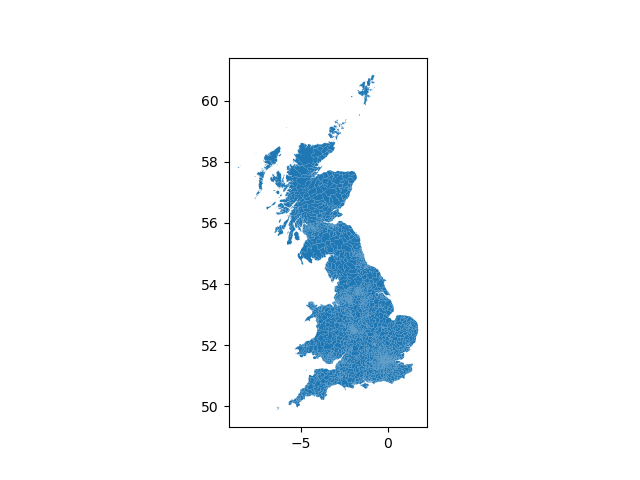

In [8]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [9]:
#Examine Header data of map
map_df.head()

,name,geometry
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57..."
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57..."
3,AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525..."
4,AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619..."


In [10]:
mappable_data = df2.groupby('PostCode_District').agg({'sf_occupied_million': 'sum'})
mappable_data.sort_values(by='sf_occupied_million', ascending=False)

,sf_occupied_million
PostCode_District,
NN6,7.2
SN3,7.0
NN4,6.8
DE74,6.2
LE17,6.1
...,...
M90,0.2
BL3,0.2
SO15,0.2


In [11]:
reset_index = map_df.set_index("name")
merged = reset_index.join(mappable_data)
merged["sf_occupied_million"] = merged["sf_occupied_million"].fillna(0)
merged

,geometry,sf_occupied_million
name,,
AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",0.0
AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",0.0
AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",0.0
AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525...",0.0
AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619...",0.0
...,...,...
YO90,"MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...",0.0
YO91,"POLYGON ((-1.06530 53.97796, -1.06634 53.97830...",0.0
ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",0.0


<IPython.core.display.Javascript object>


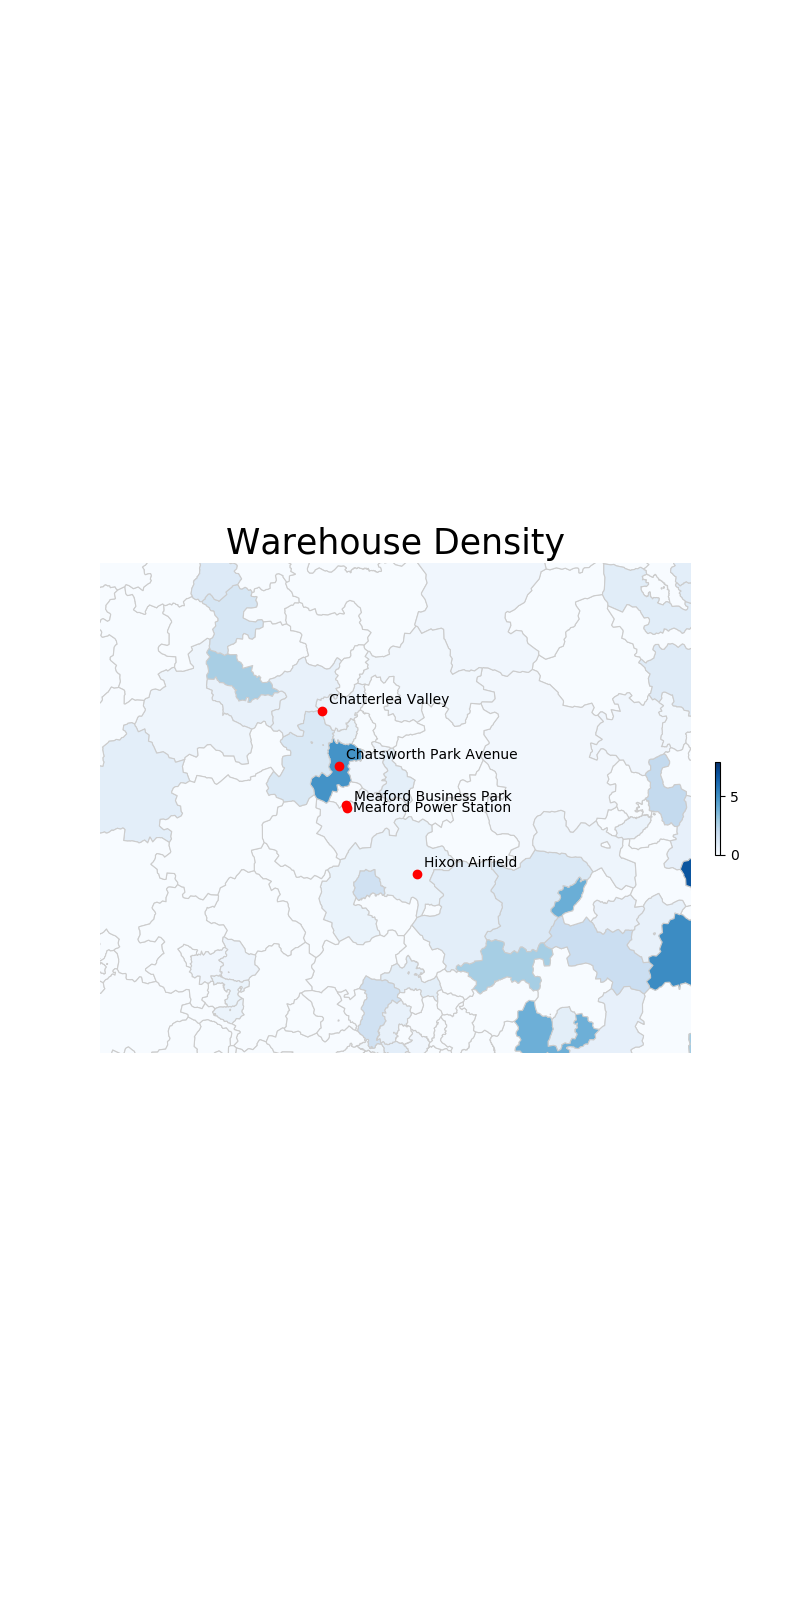

In [12]:
variable = "sf_occupied_million"
vmin, vmax = 0, 8
fig, ax = plt.subplots(1, figsize=(8, 16))

# add a title and remove axis
ax.set_title("Warehouse Density", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)

for x in all_points['Terminal']:
    ax.annotate(x, (all_points[all_points['Terminal'].str.contains(x)]["Long"].iloc[0], all_points[all_points['Terminal'].str.contains(x)]["Lat"].iloc[0]), xycoords='data', xytext=all_points[all_points['Terminal'].str.contains(x)]["map_offset"].iloc[0], textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
all_points.plot(ax=ax, color="red")
